In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 09 - CNN with Fibonacci 

### v3.0 - 6 groups - tune left of 3

by Louis Yang

Use Fibonacci series median instead of median. The Fib. median are now compute on both training and CV set separately.

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained CNN as prediction.

Modified from 'model_9_CNN_with_Fibonacci_0_separate_Fib_median_1_explore'

Test on stage 2 data

In [2]:
model_name = 'model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect

In [4]:
def arr_info(arr_list):
    print('shape, min, max, median, stdev')
    for arr in arr_list:
        print(arr.shape, arr.min(), arr.max(), np.median(arr), arr.std())

## Input

In [5]:
train_file = 'train_2.csv'

In [6]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file)
print('done!')

%%% Reading data train_2.csv ... done!


In [7]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [8]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 794 entries, Page to 2017-08-31
dtypes: float64(793), object(1)
memory usage: 878.8+ MB


In [9]:
input_df_dates = input_df.columns[1:]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
       '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object', length=793)

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [10]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [11]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [12]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [13]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [14]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2016-04-29', '2016-06-30')

In [15]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [16]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [17]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2017-04-28', '2017-06-29')

In [18]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [19]:
weekday(X_input_first_day), weekday(X_output_first_day)

(4, 4)

Both are Wednesday (2).

#### Y

In [20]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [21]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-07-01', '2016-09-01')

In [22]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [23]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [24]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-06-30', '2017-08-31')

In [25]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [26]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(4, 4)

Both are Sunday (6).

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [27]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]

In [28]:
fib_length = max(windows); fib_length

329

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [29]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11',
        '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
        ...
        '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24', '2016-06-25',
        '2016-06-26', '2016-06-27', '2016-06-28', '2016-06-29', '2016-06-30'],
       dtype='object', length=329),
 Index(['2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
        '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
        ...
        '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
        '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29'],
       dtype='object', length=329))

In [30]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(4, 4)

In [31]:
fib_output_data = input_df[fib_output_dates].values; fib_output_data

array([[  49.,   10.,   19., ...,   32.,   34.,   21.],
       [  30.,   16.,   54., ...,  127.,  104.,   20.],
       [   7.,    2.,    1., ...,    5.,    5.,    0.],
       ..., 
       [  nan,   nan,   nan, ...,   35.,   46.,   43.],
       [  nan,   nan,   nan, ...,    6.,    6.,    7.],
       [  nan,   nan,   nan, ...,   21.,   20.,   14.]])

In [32]:
fib_input_data = input_df[fib_input_dates].values; fib_input_data

array([[  4.,  11.,  10., ...,  18.,  23.,  12.],
       [  2.,  23.,  12., ...,  24.,  16.,  15.],
       [  5.,   1.,   4., ...,   5.,   1.,   4.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

#### Fibonacci median in each window

In [33]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [34]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [35]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [36]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [37]:
fib_input_median

array([ 16.5 ,  15.25,   4.  , ...,   0.  ,   0.  ,   0.  ])

In [38]:
fib_output_median

array([ 24.  ,  22.5 ,   4.  , ...,  34.  ,   7.75,  11.25])

We will use this as the center and part of the result

In [39]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

In [40]:
X_input_first_day, Y_input_final_day

('2016-04-29', '2016-09-01')

input_data contains X_input and Y_input array

In [41]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates

Index(['2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02', '2016-05-03',
       '2016-05-04', '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
       ...
       '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
       '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01'],
      dtype='object', length=126)

In [42]:
input_data = input_df[input_dates].values; input_data

array([[  15.,   29.,   18., ...,    8.,   25.,   21.],
       [  22.,   22.,   66., ...,  144.,   31.,   31.],
       [   6.,    3.,    1., ...,    4.,    2.,    5.],
       ..., 
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

##### Convert nan to number 0.

In [43]:
input_data_num = np.nan_to_num(input_data); input_data_num

array([[  15.,   29.,   18., ...,    8.,   25.,   21.],
       [  22.,   22.,   66., ...,  144.,   31.,   31.],
       [   6.,    3.,    1., ...,    4.,    2.,    5.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [44]:
input_data_num.shape

(145063, 126)

### Output Data

In [45]:
X_output_first_day, X_output_final_day, Y_output_final_day

('2017-04-28', '2017-06-29', '2017-08-31')

output_data for this self-testing script contains both X_output and Y_output

In [46]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates

Index(['2017-04-28', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02',
       '2017-05-03', '2017-05-04', '2017-05-05', '2017-05-06', '2017-05-07',
       ...
       '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
       '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object', length=126)

In [47]:
output_dates.shape

(126,)

In [48]:
output_data = input_df[output_dates].values; output_data

array([[ 24.,  20.,  36., ...,  26.,  24.,  21.],
       [ 19.,  18.,  12., ...,  29.,  34.,  25.],
       [  2.,   0.,   3., ...,   8.,  12.,   9.],
       ..., 
       [ 27.,  84.,  14., ...,  21.,  11.,   9.],
       [  7.,  10.,  13., ...,   3.,   9.,   2.],
       [ 34.,  16.,  16., ...,   9.,   6.,   5.]])

##### Convert nan to number 0.

In [49]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[ 24.,  20.,  36., ...,  26.,  24.,  21.],
       [ 19.,  18.,  12., ...,  29.,  34.,  25.],
       [  2.,   0.,   3., ...,   8.,  12.,   9.],
       ..., 
       [ 27.,  84.,  14., ...,  21.,  11.,   9.],
       [  7.,  10.,  13., ...,   3.,   9.,   2.],
       [ 34.,  16.,  16., ...,   9.,   6.,   5.]])

In [50]:
output_data_num.shape

(145063, 126)

### View

In [51]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [52]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [53]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [54]:
input_data_log.shape, input_data.shape

((145063, 126), (145063, 126))

In [55]:
output_data_log.shape, output_data.shape

((145063, 126), (145063, 126))

input_data_log

output_data_log

In [56]:
# Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

(-5.9604644775390625e-08, 5.9604644775390625e-08)

In [57]:
# Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

(-2.2351741790771484e-08, 2.2351741790771484e-08)

In [58]:
del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [59]:
gc.collect()

532

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [60]:
#input_center = log(fib_input_median).reshape(-1,1)
output_center = log(fib_output_median).reshape(-1,1)
input_center = output_center

In [61]:
input_center

array([[ 1.39794001],
       [ 1.37106786],
       [ 0.69897   ],
       ..., 
       [ 1.54406804],
       [ 0.94200805],
       [ 1.08813609]])

In [62]:
output_center

array([[ 1.39794001],
       [ 1.37106786],
       [ 0.69897   ],
       ..., 
       [ 1.54406804],
       [ 0.94200805],
       [ 1.08813609]])

#### Choice of default scale

In [63]:
input_raw_log = log(input_data)  # log of input_data with nan
output_raw_log = log(output_data)  # log of output_data with nan

In [64]:
np.median(np.nanstd(input_data_log[:,:x_length], axis=-1))

0.17800114589471497

In [65]:
np.mean(np.nanstd(input_data_log[:,:x_length], axis=-1))

0.20867408971785475

In [66]:
default_input_scale = np.nanmedian(np.nanstd(input_raw_log[:,:x_length], axis=-1))
default_input_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.17974041809557845

In [67]:
default_output_scale = np.nanmedian(np.nanstd(output_raw_log[:,:x_length], axis=-1))
default_output_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.16425448559207598

#### Compute Median and Stdev

Here we are not using this median as center

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [68]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = default_input_scale  # Prevent divid by zero 
# non-zero value is choose based on the median of other page with non-zero stdev)
input_scale  # remember sample-wised scale

array([[ 0.22042467],
       [ 0.1944303 ],
       [ 0.23390395],
       ..., 
       [ 0.17974042],
       [ 0.17974042],
       [ 0.17974042]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [69]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = default_output_scale  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.15715761],
       [ 0.23019142],
       [ 0.29932548],
       ..., 
       [ 0.30635028],
       [ 0.308769  ],
       [ 0.41433723]])

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [70]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [71]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [72]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

In [73]:
check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

([], [])

In [74]:
# Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

In [75]:
# Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

In [76]:
del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

236

## Center (Median) and Scale (Stdev) Investigation

### Center

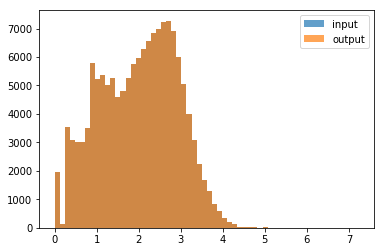

In [77]:
plt.hist(input_center, bins=60, alpha=0.7, label='input')
plt.hist(output_center, bins=60, alpha=0.7, label='output')
plt.legend()
plt.show()

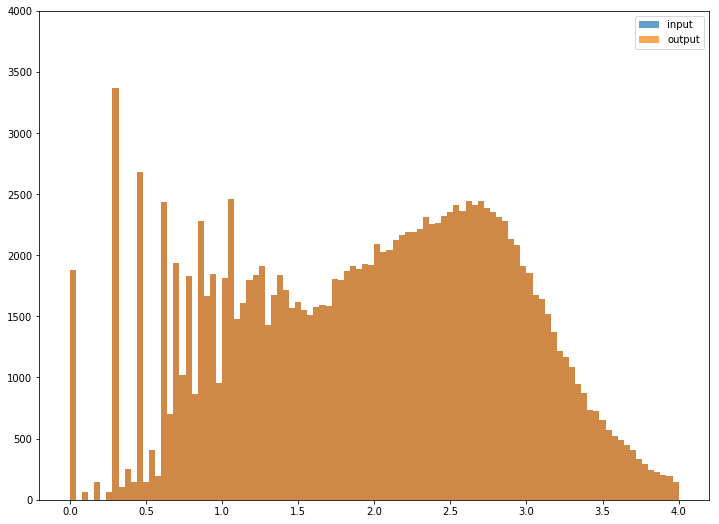

In [78]:
plt.figure(figsize=(12,9))
plt.hist(input_center, bins=100, range=[0,4], alpha=0.7, label='input')
plt.hist(output_center, bins=100, range=[0,4], alpha=0.7, label='output')
plt.ylim([0,4000])
plt.legend()
plt.show()

In [79]:
input_center_hisg = np.histogram(input_center, bins=100, range=(0,4)); input_center_hisg

(array([1879,    0,   64,    0,  142,    0,   62, 3368,  106,  249,  144,
        2681,  145,  407,  196, 2433,  700, 1939, 1017, 1830,  862, 2278,
        1663, 1846,  953, 1810, 2458, 1479, 1612, 1799, 1842, 1908, 1431,
        1677, 1841, 1713, 1572, 1614, 1555, 1508, 1575, 1593, 1585, 1807,
        1801, 1871, 1908, 1891, 1925, 1916, 2092, 2025, 2046, 2127, 2167,
        2186, 2191, 2215, 2310, 2252, 2263, 2318, 2355, 2413, 2358, 2444,
        2412, 2439, 2389, 2350, 2314, 2279, 2132, 2087, 1910, 1857, 1674,
        1641, 1517, 1368, 1217, 1165, 1088,  943,  873,  732,  723,  652,
         570,  525,  488,  451,  409,  337,  295,  245,  231,  202,  194,
         146], dtype=int64),
 array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
         0.36,  0.4 ,  0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,
         0.72,  0.76,  0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ,  1.04,
         1.08,  1.12,  1.16,  1.2 ,  1.24,  1.28,  1.32,  1.36,  1.4 ,
         1.44,  1.48,

In [80]:
ihis = 14
input_center_hisg[1][ihis], input_center_hisg[0][ihis]

(0.56000000000000005, 196)

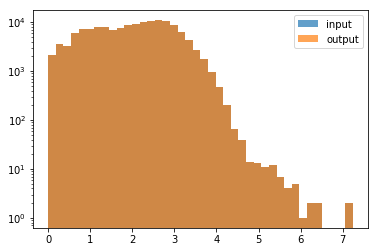

In [81]:
plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

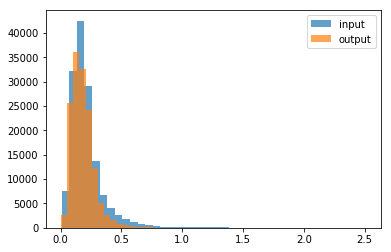

In [82]:
plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.show()

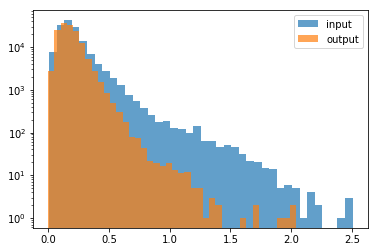

In [83]:
plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [84]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 1.6: return 2  # was 2.0
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 3.0: return 3
    elif logx < 4.0: return 4
    elif logx < 5.0: return 5
    else: return 6
group_index_v = np.vectorize(group_index)
gp_list = list(range(7)); gp_list

In [85]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
input_gp, output_gp

(array([2, 2, 1, ..., 2, 1, 2]), array([2, 2, 1, ..., 2, 1, 2]))

In [86]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[1879, 23085, 25819, 93489, 740, 51]

In [87]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[1879, 23085, 25819, 93489, 740, 51]

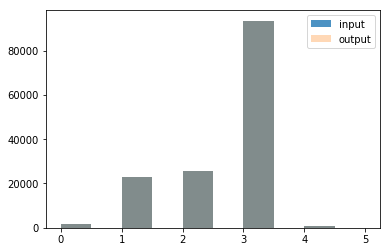

In [88]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

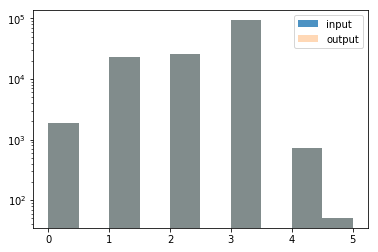

In [89]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

## Make (X,Y) pairs data from data set

In [90]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [91]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) (145063, 63)


#### Original data

In [92]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [93]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

In [94]:
X_train = X_input
Y_train = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

In [95]:
X_train_ori = X_input_ori
Y_train_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

In [96]:
train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

In [97]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -104.945597725 182.183688699 0.0250217121081 3.34816141728
(145063, 63) -104.945597725 181.969627538 -0.0156385758122 3.42135990909
(145063, 63) -57.3465699314 8.00100800101 0.0 1.27077605981
(145063, 63) -1627.7382547 51.3918797946 -0.214767758227 6.0365527548
(145063, 63) 0.0 23209383.0 126.0 63765.8619057
(145063, 63) 0.0 67264258.0 128.0 155483.953622
(145063, 63) 0.0 24630674.0 123.0 65785.6552263
(145063, 63) 0.0 18670230.0 113.0 57469.0537846


#### Min and max cases examination

In [98]:
np.argmin(Y_output, axis=0)

array([43834, 43834, 43834, 43834, 43834, 43834, 43834, 43834, 43834,
       43834, 43834, 43834, 43834, 43834,  8604,  8604,  8604,  8604,
        8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,
        8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,
        8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,
        8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,
        8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604,  8604], dtype=int64)

In [99]:
Y_output[8604]

array([  7.61558047e-01,   3.22172395e-01,   8.55613986e-01,
         1.10626085e+00,   4.47788198e-01,  -3.25220725e+00,
        -3.12482397e+00,  -4.33753441e+00,   2.27920036e-01,
        -1.44295800e+00,   7.61558047e-01,   2.90758801e-01,
        -3.34778636e+00,  -3.17285647e+01,  -1.54963575e+03,
        -1.51214135e+03,  -1.44148851e+03,  -1.51214135e+03,
        -1.44148851e+03,  -1.30217248e+03,  -1.41631209e+03,
        -1.53651729e+03,  -1.45976441e+03,  -1.46941664e+03,
        -1.46941664e+03,  -1.45046325e+03,  -1.45046325e+03,
        -1.40080712e+03,  -1.45046325e+03,  -1.62773825e+03,
        -1.46941664e+03,  -1.47944749e+03,  -1.45976441e+03,
        -1.37918125e+03,  -1.41631209e+03,  -1.54963575e+03,
        -1.50077265e+03,  -1.40080712e+03,  -1.33486635e+03,
        -1.45046325e+03,  -1.50077265e+03,  -1.30217248e+03,
        -1.56346364e+03,  -1.48988787e+03,  -1.36571741e+03,
        -1.40080712e+03,  -1.39339344e+03,  -1.35924229e+03,
        -1.30217248e+03,

In [100]:
Y_output_ori[8604]

array([ 8155.,  8141.,  8158.,  8166.,  8145.,  8028.,  8032.,  7994.,
        8138.,  8085.,  8155.,  8140.,  8025.,  7182.,    18.,    21.,
          28.,    21.,    28.,    49.,    31.,    19.,    26.,    25.,
          25.,    27.,    27.,    33.,    27.,    13.,    25.,    24.,
          26.,    36.,    31.,    18.,    22.,    33.,    43.,    27.,
          22.,    49.,    17.,    23.,    38.,    33.,    34.,    39.,
          49.,    25.,    27.,    22.,    23.,    28.,    32.,    41.,
          23.,    27.,    37.,    33.,    23.,    26.,    50.])

In [101]:
fib_output_median[8604]

8130.75

In [102]:
log(Y_output_ori[8604])

array([ 3.91147722,  3.9107311 ,  3.91163693,  3.91206256,  3.91094441,
        3.90466146,  3.90487777,  3.90281847,  3.91057105,  3.90773374,
        3.91147722,  3.91067775,  3.90449916,  3.85630587,  1.2787536 ,
        1.34242268,  1.462398  ,  1.34242268,  1.462398  ,  1.69897   ,
        1.50514998,  1.30103   ,  1.43136376,  1.41497335,  1.41497335,
        1.44715803,  1.44715803,  1.53147892,  1.44715803,  1.14612804,
        1.41497335,  1.39794001,  1.43136376,  1.56820172,  1.50514998,
        1.2787536 ,  1.36172784,  1.53147892,  1.64345268,  1.44715803,
        1.36172784,  1.69897   ,  1.25527251,  1.38021124,  1.59106461,
        1.53147892,  1.54406804,  1.60205999,  1.69897   ,  1.41497335,
        1.44715803,  1.36172784,  1.38021124,  1.462398  ,  1.51851394,
        1.62324929,  1.38021124,  1.44715803,  1.5797836 ,  1.53147892,
        1.38021124,  1.43136376,  1.70757018])

In [103]:
log(fib_output_median[8604])

3.9101840183563801

In [104]:
np.std(log(Y_output_ori[8604]))

1.0217553324861055

In [105]:
np.std(log(X_output_ori[8604]))

0.0016980961003407436

In [106]:
output_scale[8604]

array([ 0.0016981])

#### Check if the inverse transformation is correct

#Undo transformation
X_train_tt = unlog(untransform(X_train, train_center, train_scale))

X_train_tt_diff = X_train_tt - X_train_ori
X_train_tt_diff.min(), X_train_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [107]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [108]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [109]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [110]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), 1e-07, None))
    return 200. * np.nanmean(diff, axis=axis)

In [111]:
smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

(200.0, 0.0)

In [112]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(118.39849931396679, 148.1903381452849, 0.0)

In [113]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(60.417294139521594, 58.828327132034431)

In [114]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

50.9386336667 142.088333627


In [115]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

48.3250071896
40.4041165988


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [116]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D

In [357]:
#runbelow
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Reshape((-1, 1))(layer_0)
    layer_t = Conv1D(120, kernel_size=5, activation='relu')(layer_t)
    layer_t = AveragePooling1D(pool_size=2)(layer_t)
    layer_t = Flatten()(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_absolute_error', metrics=[k_smape])
    model.summary()
    models.append(model)

Group: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 63)                0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 63, 1)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 59, 120)           720       
_________________________________________________________________
average_pooling1d_19 (Averag (None, 29, 120)           0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 3480)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 120)               417720    
_________________________________________________________________
dropout_37 (Dropout)         (None, 120)               0         
_

About 22s for 1 epoch on i5-750 CPU

In [358]:
len(gp_list)

6

In [359]:
epochs_list = [40,40,40,40,40,60,80]

In [360]:
%%time
hists = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list):
    print('Group:',gp)
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05, verbose=2)
    #validation_data=(X_val, Y_val))
    hists.append(hist)

Group: 0
Train on 1785 samples, validate on 94 samples
Epoch 1/40
1s - loss: 0.9024 - k_smape: 196.8299 - val_loss: 1.6437 - val_k_smape: 199.9895
Epoch 2/40
0s - loss: 0.8929 - k_smape: 199.9816 - val_loss: 1.6437 - val_k_smape: 199.9872
Epoch 3/40
0s - loss: 0.8928 - k_smape: 199.9879 - val_loss: 1.6436 - val_k_smape: 199.9934
Epoch 4/40
0s - loss: 0.8928 - k_smape: 199.9904 - val_loss: 1.6436 - val_k_smape: 199.9926
Epoch 5/40
0s - loss: 0.8927 - k_smape: 199.9913 - val_loss: 1.6435 - val_k_smape: 199.9942
Epoch 6/40
0s - loss: 0.8927 - k_smape: 199.9919 - val_loss: 1.6436 - val_k_smape: 199.9929
Epoch 7/40
0s - loss: 0.8927 - k_smape: 199.9922 - val_loss: 1.6435 - val_k_smape: 199.9931
Epoch 8/40
0s - loss: 0.8927 - k_smape: 199.9926 - val_loss: 1.6436 - val_k_smape: 199.9930
Epoch 9/40
0s - loss: 0.8927 - k_smape: 199.9546 - val_loss: 1.6435 - val_k_smape: 199.9927
Epoch 10/40
0s - loss: 0.8927 - k_smape: 199.9916 - val_loss: 1.6435 - val_k_smape: 199.9947
Epoch 11/40
0s - loss: 0

4s - loss: 1.1463 - k_smape: 117.8676 - val_loss: 0.8474 - val_k_smape: 120.4339
Epoch 9/40
4s - loss: 1.1467 - k_smape: 117.9046 - val_loss: 0.8516 - val_k_smape: 119.7980
Epoch 10/40
4s - loss: 1.1395 - k_smape: 117.4084 - val_loss: 0.8671 - val_k_smape: 122.8216
Epoch 11/40
4s - loss: 1.1441 - k_smape: 117.4203 - val_loss: 0.8411 - val_k_smape: 117.2172
Epoch 12/40
4s - loss: 1.1350 - k_smape: 116.4498 - val_loss: 0.8490 - val_k_smape: 119.2027
Epoch 13/40
4s - loss: 1.1353 - k_smape: 116.1819 - val_loss: 0.8670 - val_k_smape: 123.7276
Epoch 14/40
4s - loss: 1.1415 - k_smape: 117.0042 - val_loss: 0.8488 - val_k_smape: 119.6181
Epoch 15/40
4s - loss: 1.1322 - k_smape: 116.2641 - val_loss: 0.8431 - val_k_smape: 116.4458
Epoch 16/40
4s - loss: 1.1301 - k_smape: 115.9574 - val_loss: 0.8449 - val_k_smape: 118.1321
Epoch 17/40
4s - loss: 1.1258 - k_smape: 115.8021 - val_loss: 0.8405 - val_k_smape: 115.0733
Epoch 18/40
4s - loss: 1.1320 - k_smape: 115.7374 - val_loss: 0.8438 - val_k_smape:

0s - loss: 1.5625 - k_smape: 94.1783 - val_loss: 1.1127 - val_k_smape: 98.8972
Epoch 18/40
0s - loss: 1.5888 - k_smape: 90.6177 - val_loss: 1.1038 - val_k_smape: 97.3207
Epoch 19/40
0s - loss: 1.5653 - k_smape: 90.5389 - val_loss: 1.1538 - val_k_smape: 98.1733
Epoch 20/40
0s - loss: 1.5270 - k_smape: 89.5033 - val_loss: 1.0253 - val_k_smape: 94.6411
Epoch 21/40
0s - loss: 1.5092 - k_smape: 88.0525 - val_loss: 1.1395 - val_k_smape: 97.1031
Epoch 22/40
0s - loss: 1.4982 - k_smape: 88.6300 - val_loss: 1.0221 - val_k_smape: 95.0610
Epoch 23/40
0s - loss: 1.4741 - k_smape: 89.2632 - val_loss: 1.0147 - val_k_smape: 94.5735
Epoch 24/40
0s - loss: 1.4545 - k_smape: 87.2680 - val_loss: 1.3791 - val_k_smape: 96.7825
Epoch 25/40
0s - loss: 1.4830 - k_smape: 85.7540 - val_loss: 1.0292 - val_k_smape: 95.5419
Epoch 26/40
0s - loss: 1.4764 - k_smape: 89.1898 - val_loss: 0.9965 - val_k_smape: 93.3443
Epoch 27/40
0s - loss: 1.4769 - k_smape: 84.5115 - val_loss: 1.1946 - val_k_smape: 93.4820
Epoch 28/40

### Training History

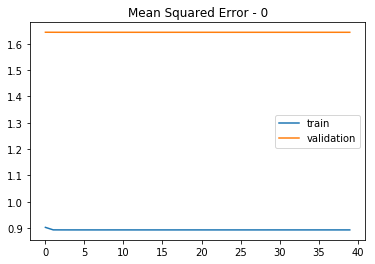

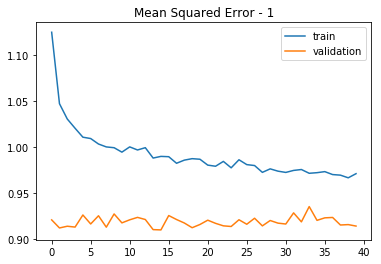

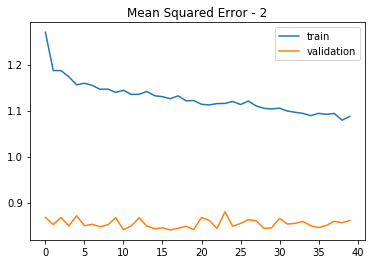

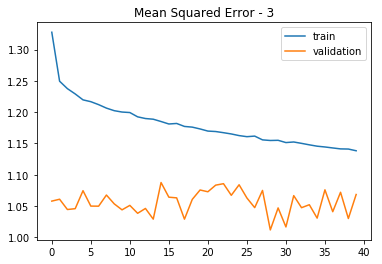

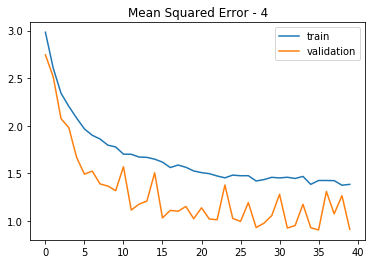

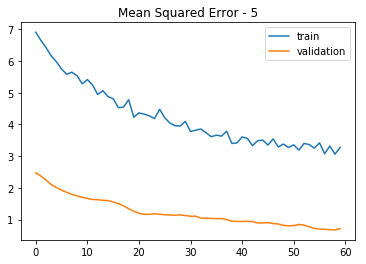

In [361]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

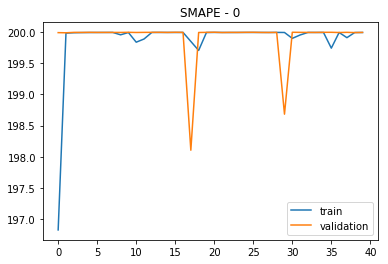

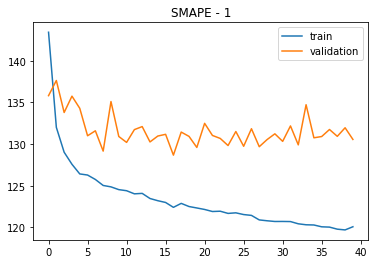

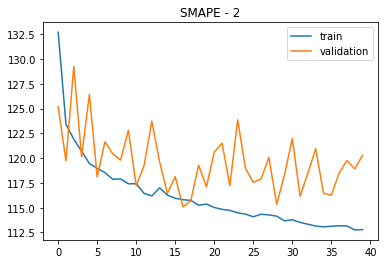

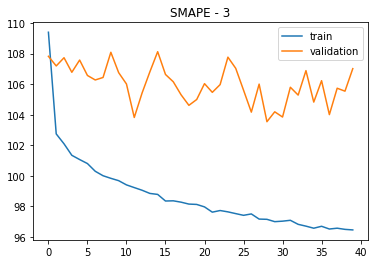

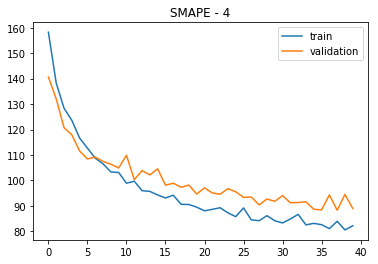

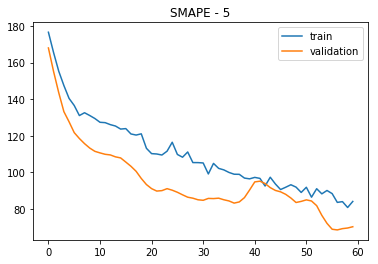

In [362]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

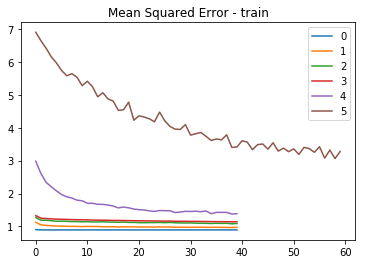

In [363]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

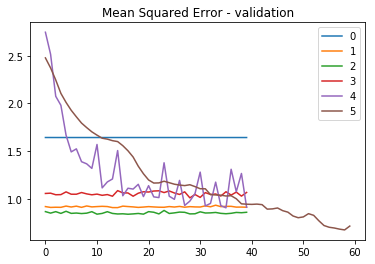

In [364]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

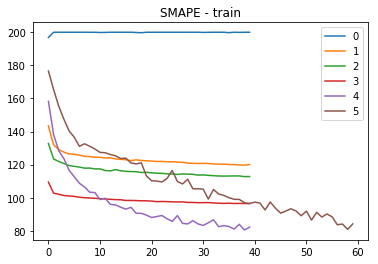

In [365]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

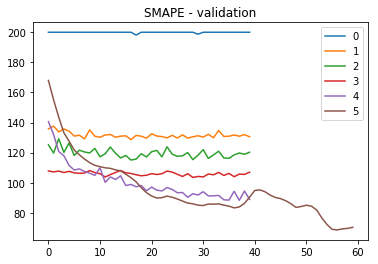

In [366]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using Output Set

In [367]:
if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))


1879/1879 [==============================] - 0s     
[0.48474414813956279, 199.99649556207174]

22656/23085 [============================>.] - ETA: 0s[0.9398075398775001, 154.1773055848503]

25760/25819 [============================>.] - ETA: 0s[0.99793322535394824, 151.48764946497752]

93184/93489 [============================>.] - ETA: 0s[1.1436427303739138, 133.75847005589603]

672/740 [==========================>...] - ETA: 0s[1.6307720403413515, 125.56093923207875]

32/51 [=================>............] - ETA: 0s[1.5864248743244247, 96.862707549450448]


### Predict for Output Set

In [368]:
Y_output_pred_list = []
for (gp, model, X) in zip(gp_list, models, X_output_list):
    print(gp)
    Y_output_pred_list.append(model.predict(X))

0
1
2
3
4
5


Find the original index

In [369]:
output_index_range = np.arange(len(output_gp)); output_index_range

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [370]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [371]:
for o in output_index_list:
    print(o.shape)

(1879,)
(23085,)
(25819,)
(93489,)
(740,)
(51,)


In [372]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([  1475,   3412,   3467, ..., 123025, 139119, 140151])

In [373]:
Y_output_pred_comb = np.concatenate(Y_output_pred_list)

In [374]:
Y_output_pred_temp = [0]*len(output_index_list_comb)
for index, y in zip(output_index_list_comb, Y_output_pred_comb):
    Y_output_pred_temp[index] = y
Y_output_pred = np.array(Y_output_pred_temp)
del Y_output_pred_temp

In [375]:
# Inverse transform Y of output
Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                      output_center, output_scale))

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

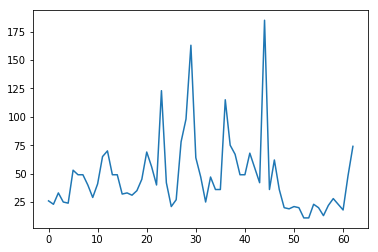

In [376]:
view(X_output_ori[126420])

### Model Score

In [377]:
# SMAPE scores for the model
if test_length: 
    model_smape_score = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
    model_smape_score_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
    print(model_smape_score, model_smape_score_0)

39.2827171544 42.5949138721


In [378]:
if test_length: # SMAPE score for using Fibonacci median
    fib_smape_score = smape(Y_output_raw, Y_output_fib)
    print(fib_smape_score)

40.4041165988


### Group Scores
For self-testing stage only

In [379]:
# Prediction Y_output in group
Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]    

In [380]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [381]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [382]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

In [383]:
if test_length: print(count_not_nan(Y_output_raw))

8904608


In [384]:
# Group SMAPE scores
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
                  in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape = [smape(Y, Y_p) for Y, Y_p 
                in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_output_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [385]:
if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape_score, '%6.2f' % model_smape_score_0)

[Group SMAPE]
W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio
155.12 145.98          1.12   1879          0.542
 65.90  75.89          9.75  23085          0.906
 42.87  43.40          7.80  25819          0.997
 31.09  32.11         20.44  93489          0.994
 33.04  39.32          0.17    740          0.962
 16.06  27.24          0.01     51          0.936
-------------------------------------------------
 39.28  42.59


In [386]:
n_not_nan_gp

[64128, 1317266, 1620990, 5854376, 44840, 3008]

if test_length:
    x_tmp = 0.
    for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
        s_tmp = smape(Y, Y_p) * len(Y)
        print(s_tmp / tot_n)
        x_tmp += s_tmp
    print('SMAPE(0):', '%6.2f' % (x_tmp / tot_n))

#the correct one (excluding nan)
n_not_nan = count_not_nan(Y_output_raw)
x_tmp = 0.
for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list):
    s_tmp = smape(Y, Y_p) * count_not_nan(Y)
    print(s_tmp / n_not_nan)
    x_tmp += s_tmp
x_tmp / n_not_nan

### Individual Page Scores

In [387]:
if test_length:
    smape_Y_pred_na = np.array([smape(yp, y) for yp, y 
                                in zip(Y_output_pred_ori, Y_output_raw)])
    smape_Y_pred = np.nan_to_num(smape_Y_pred_na)

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


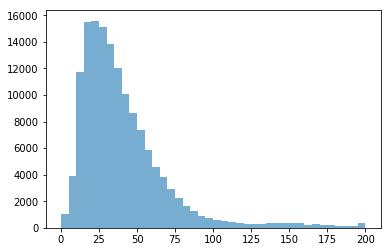

In [388]:
if test_length:
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

## Compare

In [389]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()

In [390]:
def comp_view(x1, x2, title=None, show=True):
    plt.plot(x1)
    plt.plot(x2)
    if title: plt.title(title)
    if show: plt.show()

def comp_examine(data1, data2, view_n=10, view_list=None):
    n_data = len(data1)
    if not data1.shape == data2.shape: print(data1.shape, data2.shape, 'not the same length')
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        comp_view(data1[i], data2[i], title='i = ' + str(i))
    return list(view_list)

def multi_view(x_list, title=None, show=True, xlim=None, ylim=None, yscale='linear'):
    plt.yscale(yscale)
    for x in x_list:
        plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()

def examine_list(data_list, view_n=10, view_list=None, xlim=None, ylim=None, yscale='linear'):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i), xlim=xlim, ylim=ylim, yscale=yscale)
    return list(view_list)

view_list = None

In [391]:
def examine_list_gp(data_list, data_gp, view_n=10, view_list=None, xlim=None, ylim=None, yscale='linear'):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i) + ' gp = ' + str(data_gp[i]), xlim=xlim, ylim=ylim, yscale=yscale)
    return list(view_list)

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [392]:
view_list

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

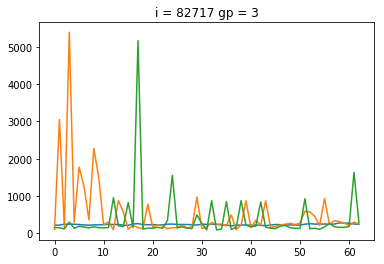

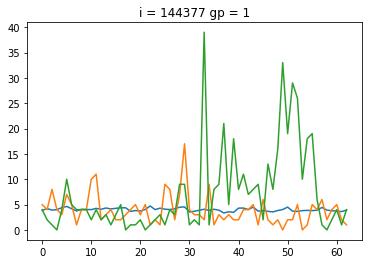

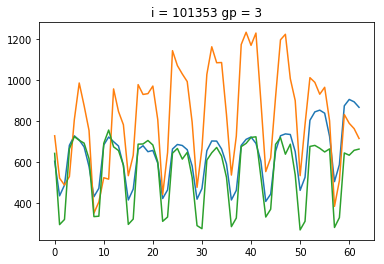

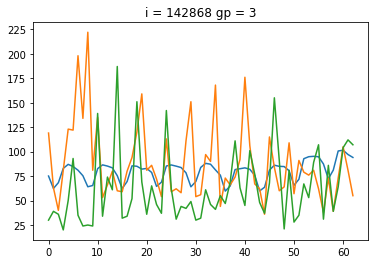

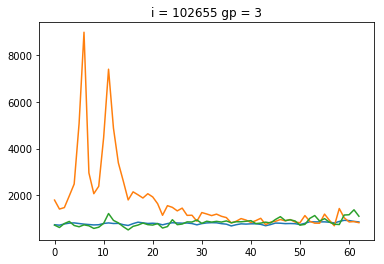

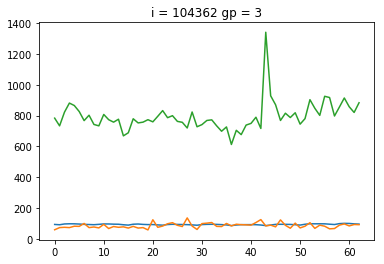

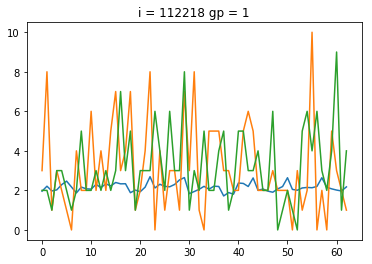

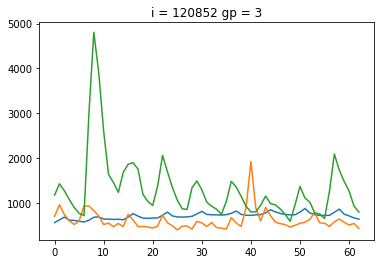

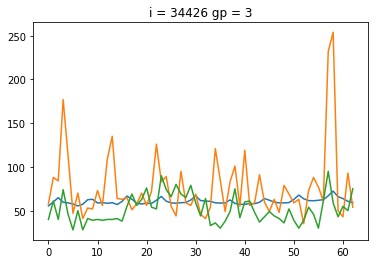

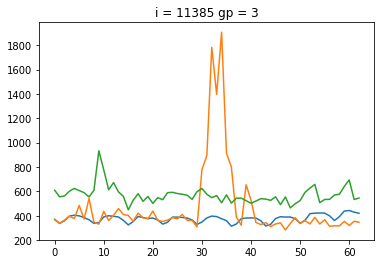

In [393]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

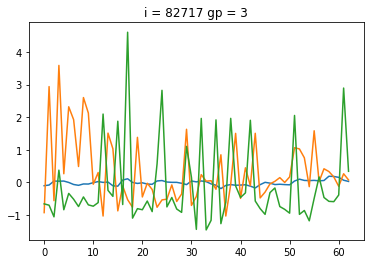

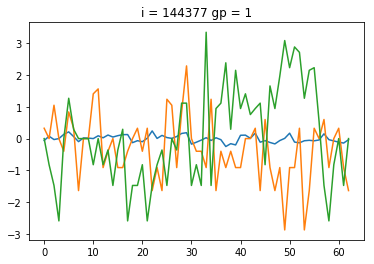

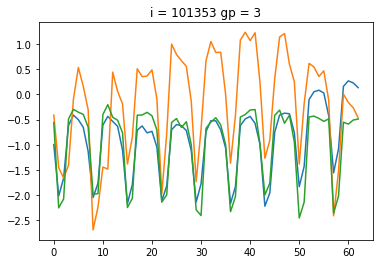

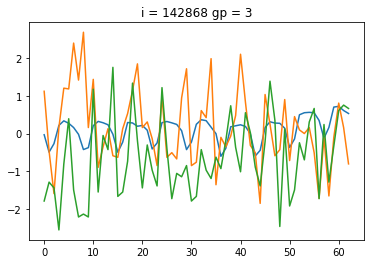

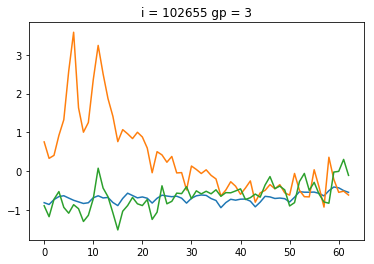

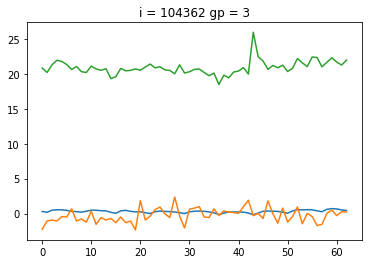

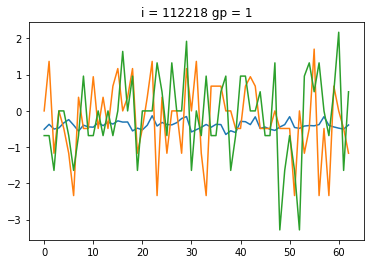

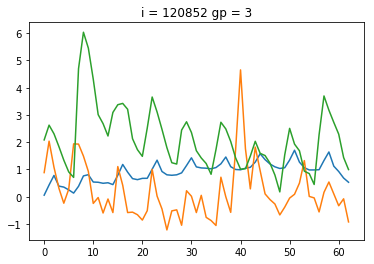

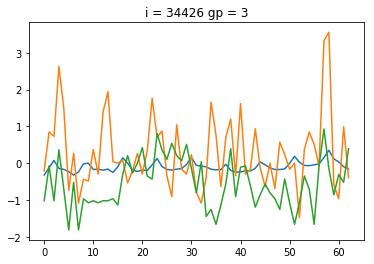

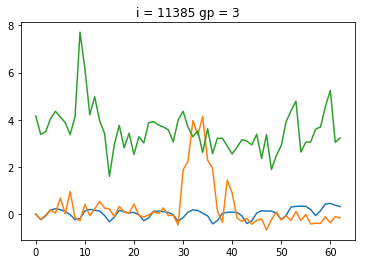

In [394]:
view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

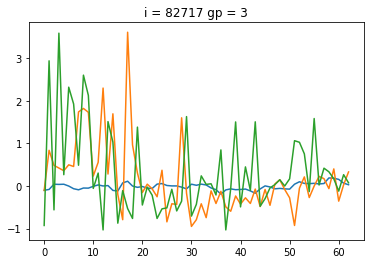

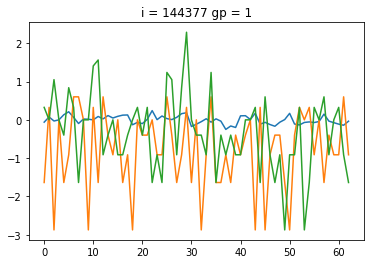

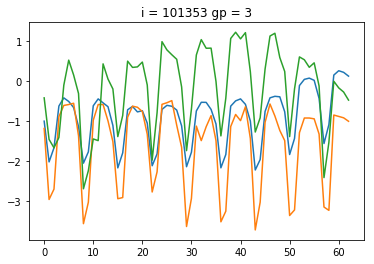

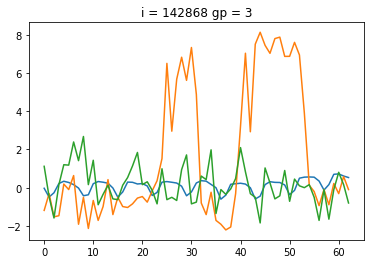

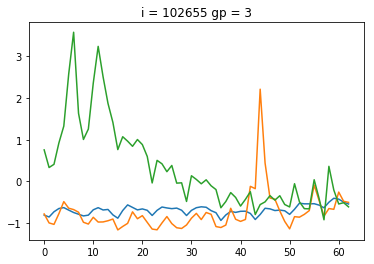

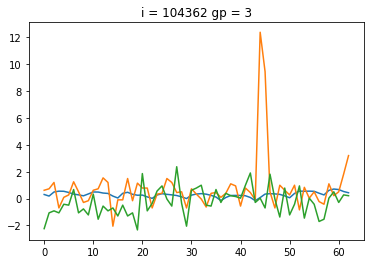

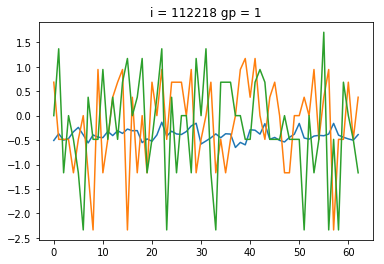

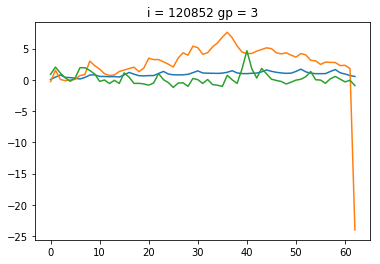

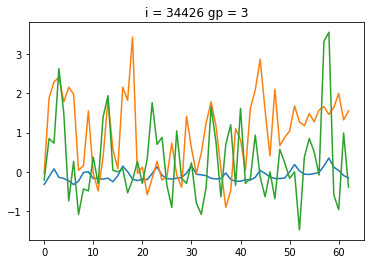

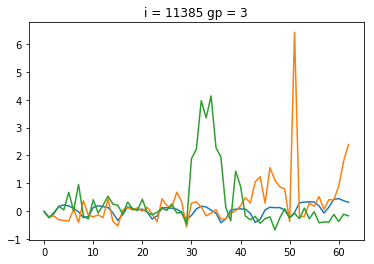

In [395]:
if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

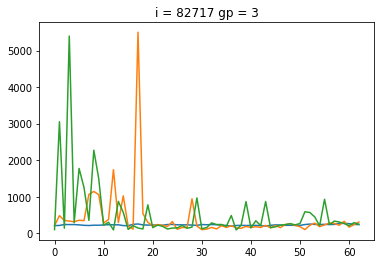

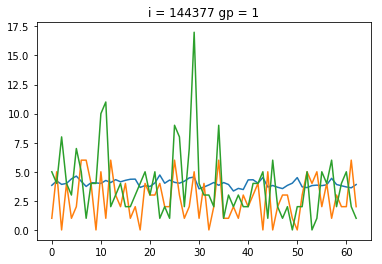

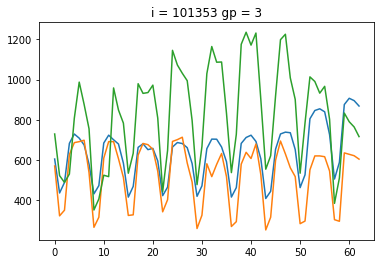

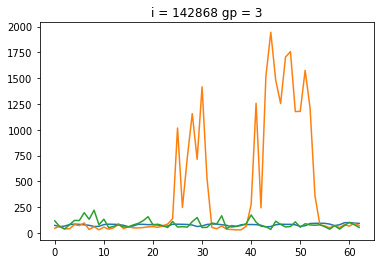

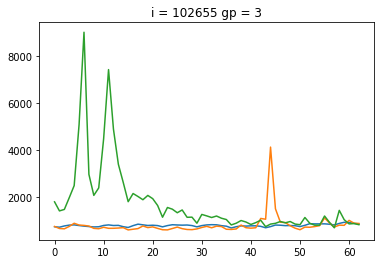

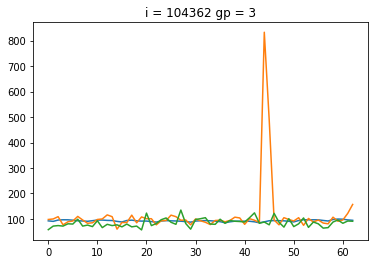

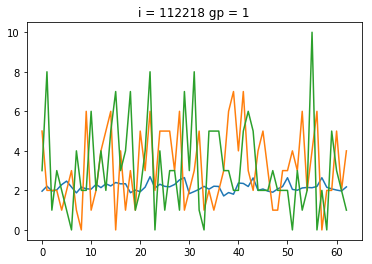

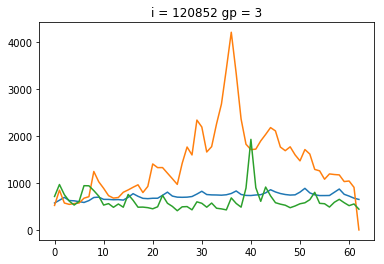

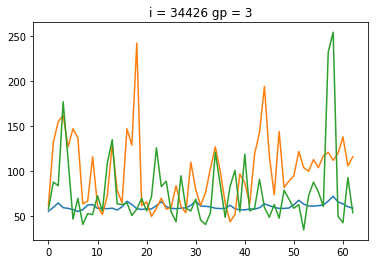

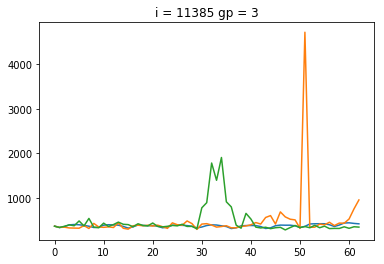

In [396]:
if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

comp_examine(input_df.iloc[:,-63*2:-63].values,input_df.iloc[:,-63:].values, view_list=view_list)

In [397]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]; view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

In [398]:
view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

[29.264224601026374,
 80.448200949987225,
 24.224033235185065,
 44.115528841482892,
 29.854686458108436,
 23.394708740716847,
 14.877563200442973,
 26.367217911025985,
 39.602501893287702,
 18.393348192291722]

In [399]:
view_list_review = [score < model_smape_score for score in view_list_smape]; view_list_review

[True, False, True, False, True, True, True, True, False, True]

In [400]:
view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

[93175, 5464, 119659, 64392, 73856, 140331, 25591]

In [401]:
view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

[13986, 89589, 19234]

#### Good cases

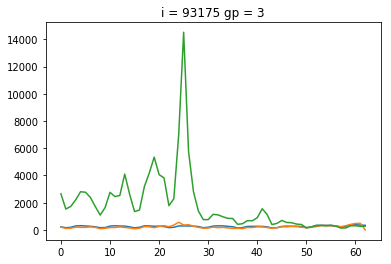

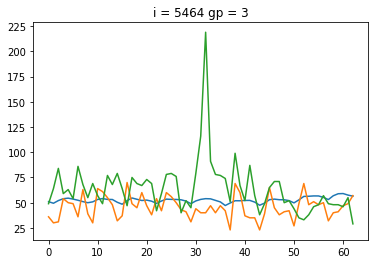

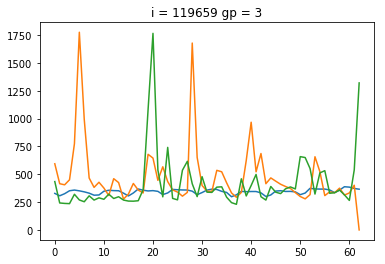

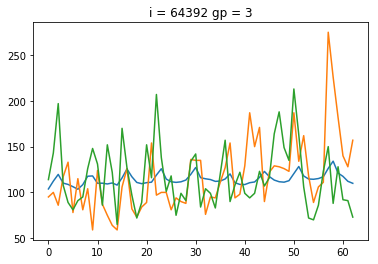

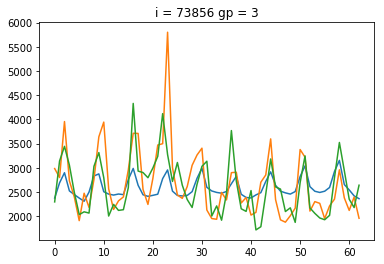

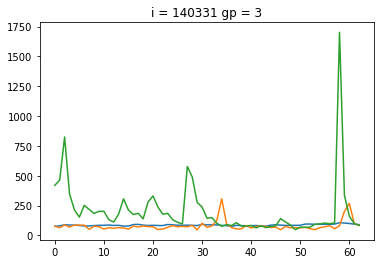

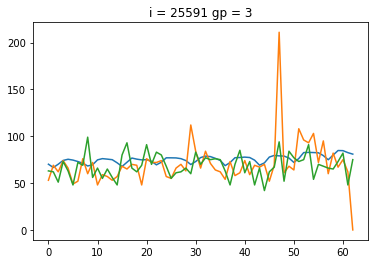

[93175, 5464, 119659, 64392, 73856, 140331, 25591]

In [402]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

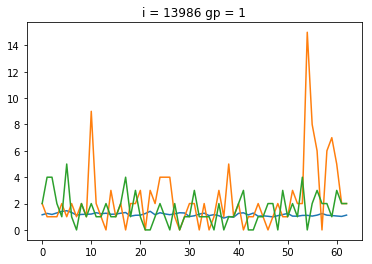

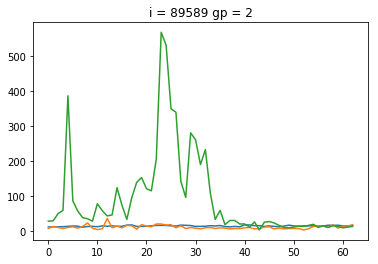

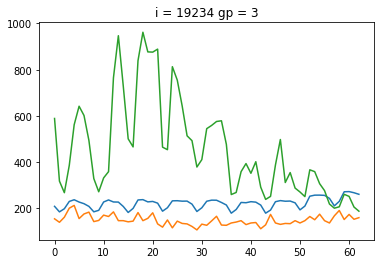

[13986, 89589, 19234]

In [403]:
examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

In [404]:
print(output_center[view_list_good].reshape(-1))
print(output_center[view_list_bad].reshape(-1))

[ 2.61225391  1.78532984  2.56555268  2.07280115  3.41796964  2.14921911
  1.85125835]
[ 0.30103     1.46612587  2.61489722]


In [405]:
print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

[ 0.45758495  0.13744919  0.17725717  0.12048413  0.09144428  0.29619523
  0.07964336]
[ 0.20849044  0.50503777  0.18993217]


In [406]:
output_gp[view_list_good]

array([3, 3, 3, 3, 3, 3, 3])

In [407]:
output_gp[view_list_bad]

array([1, 2, 3])

In [408]:
gp_smape

[155.11685394528988,
 65.902963590822566,
 42.871732533916585,
 31.090224063512682,
 33.03549118287826,
 16.059790849395021]

In [409]:
gp_n

[1879, 23085, 25819, 93489, 740, 51]

#### Case 93175

In [410]:
i = 93175

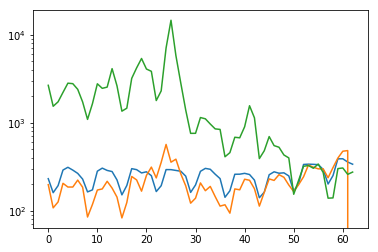

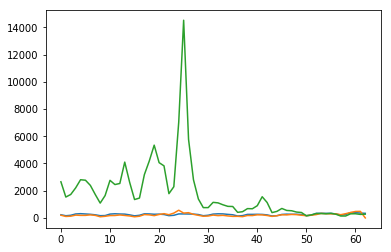

In [411]:
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

In [412]:
smape(Y_output_pred_ori[i], Y_output_raw[i])

29.264224601026374

In [413]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 2.61225391]),
 array([ 2.61225391]),
 array([ 0.4493528]),
 array([ 0.45758495]))

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

review_Y = np.array([score < model_smape_score for score in smape_Y_pred])

np.arange(len(Y_output_pred))

good_Y_index = np.arange(len(Y_output_pred))[review_Y]; good_Y_index

bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; bad_Y_index

good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]

bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

good_output_scale.min(), good_output_scale.max()

bad_output_scale.min(), bad_output_scale.max()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

### stdev/median

output_scale

output_center

output_factor_1 = (output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

### SMAPE Distribution Investigation

In [414]:
if test_length:
    smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]

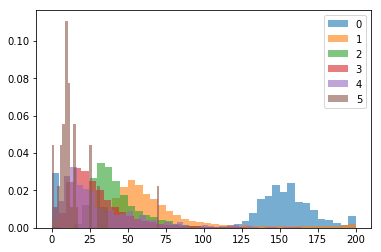

In [415]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.legend()
    plt.show()

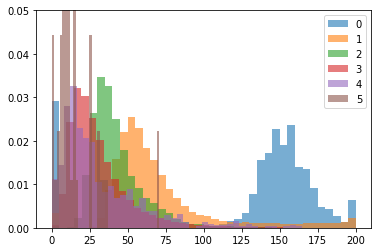

In [416]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

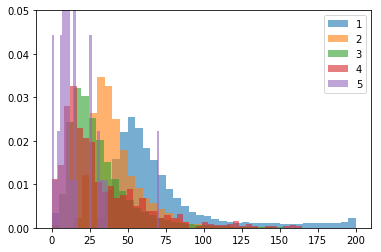

In [417]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

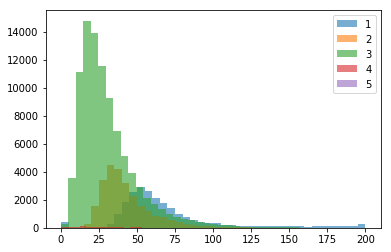

In [418]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

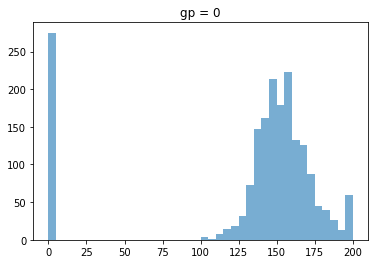

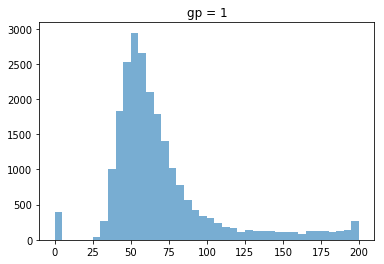

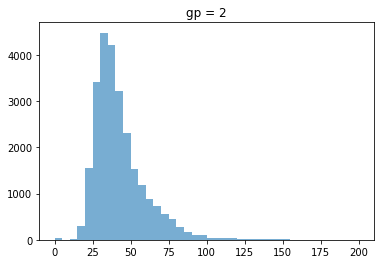

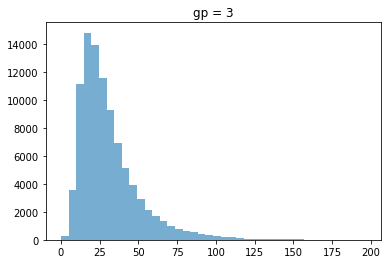

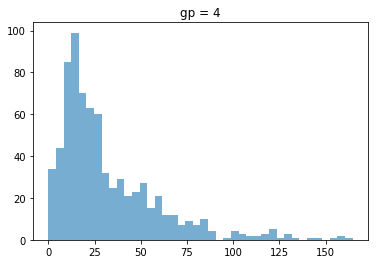

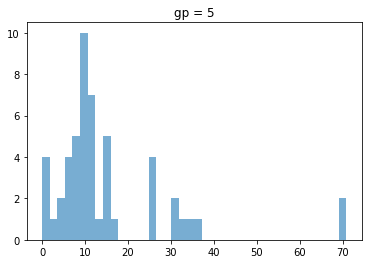

In [419]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

#### SMAPE for Fibonacci median

What if we replace the group 1 prediction by fib median

In [420]:
Y_output_fib_list = [Y_output_fib[output_gp == gp] 
                     for gp in gp_list]

In [421]:
Y_output_fib_list[1]

array([[ 4.  ],
       [ 6.  ],
       [ 5.25],
       ..., 
       [ 4.  ],
       [ 7.5 ],
       [ 7.75]])

In [422]:
# The actual score with nan
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]
    print('#### ' + model_name + ' ')
    print('Model   |Fibonacci|#ofpages')
    print('--------|---------|-------')
    for score1, score2, n in zip(gp_smape, gp_smape_fib, gp_n):
        print('%7.3f |'%score1, '%7.3f |'%score2, '%6d'%n)

#### model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 
Model   |Fibonacci|#ofpages
--------|---------|-------
155.117 |  57.385 |   1879
 65.903 |  61.354 |  23085
 42.872 |  42.800 |  25819
 31.090 |  34.888 |  93489
 33.035 |  35.621 |    740
 16.060 |  20.224 |     51


#### model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 3
Model   |Fibonacci|#ofpages
--------|---------|-------
155.117 |  57.385 |   1879
 65.903 |  61.354 |  23085
 42.872 |  42.800 |  25819
 31.090 |  34.888 |  93489
 33.035 |  35.621 |    740
 16.060 |  20.224 |     51

#### model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 2
Model   |Fibonacci|#ofpages
--------|---------|-------
160.652 |  57.385 |   1879
 65.832 |  61.354 |  23085
 42.979 |  42.800 |  25819
 31.167 |  34.888 |  93489
 33.530 |  35.621 |    740
 16.455 |  20.224 |     51

#### model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 1
Model   |Fibonacci|#ofpages
--------|---------|-------
161.422 |  57.385 |   1879
 65.807 |  61.354 |  23085
 43.232 |  42.800 |  25819
 31.135 |  34.888 |  93489
 33.545 |  35.621 |    740
 16.265 |  20.224 |     51

#### model_9_CNN_with_Fibonacci_2_7_groups 3
Model   |Fibonacci|#ofpages
--------|---------|-------
133.321 |  57.385 |   1879
 65.671 |  61.354 |  23085
 40.367 |  40.612 |  43691
 31.507 |  34.829 |  56074
 25.918 |  32.716 |  19543
 32.824 |  35.621 |    740
 16.788 |  20.224 |     51

#### model_9_CNN_with_Fibonacci_2_7_groups 2
Model   |Fibonacci|#ofpages
--------|---------|-------
165.093 |  57.385 |   1879
 65.219 |  61.354 |  23085
 40.671 |  40.612 |  43691
 31.524 |  34.829 |  56074
 25.955 |  32.716 |  19543
 31.835 |  35.621 |    740
 16.070 |  20.224 |     51

#### model_9_CNN_with_Fibonacci_2_7_groups 1
Model   |Fibonacci|#ofpages
--------|---------|-------
130.182 |  57.385 |   1879
 65.117 |  61.354 |  23085
 40.269 |  40.612 |  43691
 31.004 |  34.829 |  56074
 26.082 |  32.716 |  19543
 32.330 |  35.621 |    740
 16.303 |  20.224 |     51

#### model_9_CNN_with_Fibonacci_0_separate_Fib_median 1
Model   |Fibonacci|#ofpages
--------|---------|-------
138.688 |  57.385 |   1879
 64.797 |  61.354 |  23085
 41.218 |  40.612 |  43691
 29.877 |  34.284 |  75617
 31.746 |  35.621 |    740
 16.744 |  20.224 |     51

#### model_7_CNN_with_Fibonacci_8_mean_absolute_error 3
Model| Fib| number in the group
-|-|-
162.983 | 115.887| 3422
64.946 | 61.823| 23105
44.284 | 45.496| 40264
36.073 | 40.368| 77416
38.975 | 40.033| 790
31.033 | 33.144| 66

#### model_7_CNN_with_Fibonacci_8_mean_absolute_error 2
Model| Fib| number in the group
-|-|-
159.379 | 115.887| 3422
66.444 | 61.823| 23105
44.428 | 45.496| 40264
35.696 | 40.368| 77416
39.093 | 40.033| 790
31.868 | 33.144| 66

# **Fib do better in group 0 and 1!!!**

#### SMAPE distribution for Fib

In [423]:
if test_length:
    smape_Y_fib_na = np.array([smape(yp, y) for yp, y 
                               in zip(Y_output_fib, Y_output_raw)])
    smape_Y_fib = np.nan_to_num(smape_Y_fib_na)

    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


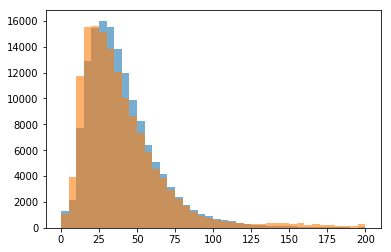

In [424]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6)
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

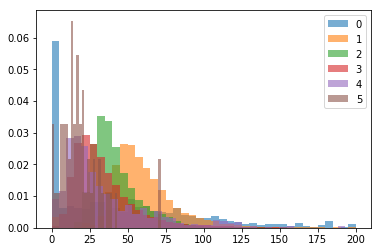

In [425]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

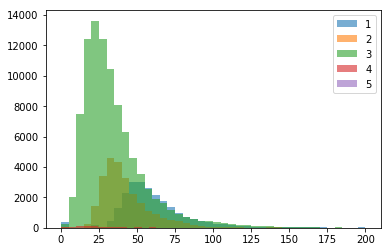

In [426]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list[1:])),smape_Y_fib_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

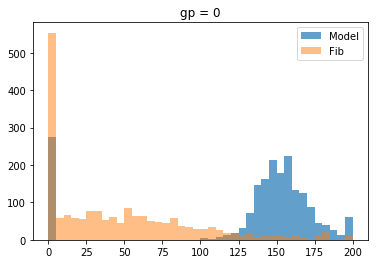

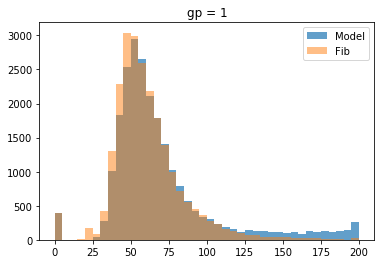

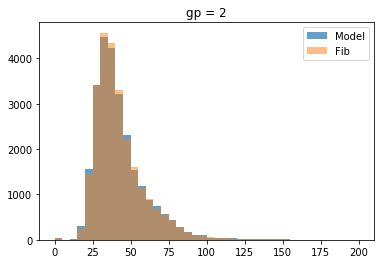

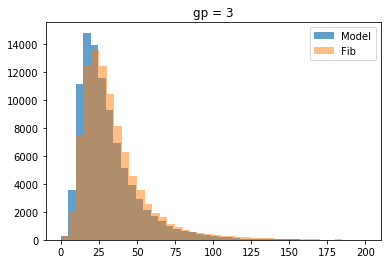

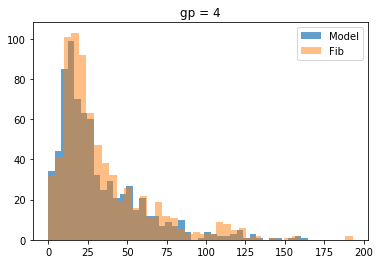

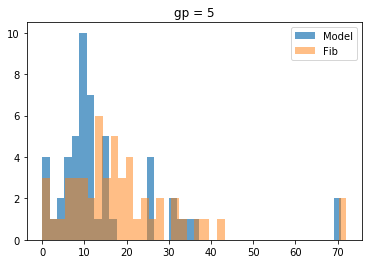

In [427]:
if test_length:
    for i in range(len(smape_Y_fib_list)):
        plt.hist(smape_Y_pred_list[i], bins=40, alpha=0.7, label='Model')
        plt.hist(smape_Y_fib_list[i], bins=40, alpha=0.5, label='Fib')
        plt.title('gp = '+str(i))
        plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Combine
Combine group 0, 1 from Fib and rest from the model

In [428]:
Y_output_fib.shape

(145063, 1)

In [429]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [430]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

# The combined result
Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori

if test_length: 
    model_combined_smape_score = smape(Y_output_fmc_ori, Y_output_raw)
    print('%6.3f' % model_combined_smape_score, '(%6.3f)' % model_smape_score, '- Model -', model_name + ' ')

37.906 (39.283) - Model - model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 


In [431]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)|(output_gp == 2)).reshape(-1,1)

# The combined result
Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori

if test_length: 
    model_combined_smape_score = smape(Y_output_fmc_ori, Y_output_raw)
    print('%6.3f' % model_combined_smape_score, '(%6.3f)' % model_smape_score, '- Model -', model_name + ' ')

37.893 (39.283) - Model - model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 


In [432]:
model_name

'model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3'

#### Combined Scores:
37.906 (39.283) - Model 9.3.0 - model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 4

37.949 (39.215) - Model 9.3.0 - model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 3

37.979 (39.385) - Model 9.3.0 - model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 2

38.004 (39.411) - Model 9.3.0 - model_9_CNN_with_Fibonacci_3_6_groups_tuned_0_left_of_3 1

37.879 (39.043) - Model 9.2.0 - model_9_CNN_with_Fibonacci_2_7_groups 4

38.070 (39.255) - Model 9.2.0 - model_9_CNN_with_Fibonacci_2_7_groups 3

38.170 (39.517) - Model 9.2.0 - model_9_CNN_with_Fibonacci_2_7_groups 2

37.861 (38.942) - Model 9.2.0 - model_9_CNN_with_Fibonacci_2_7_groups 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.174 (44.159) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 3

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

43.038 (43.990) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 1

43.479 (44.659) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 3

43.804 (45.033) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.948 (46.090) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 4

43.762 (44.885) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 3

43.805 (44.996) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 2

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [433]:
Y_output_dates

Index(['2017-06-30', '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
       '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08', '2017-07-09',
       '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13', '2017-07-14',
       '2017-07-15', '2017-07-16', '2017-07-17', '2017-07-18', '2017-07-19',
       '2017-07-20', '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
       '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-29',
       '2017-07-30', '2017-07-31', '2017-08-01', '2017-08-02', '2017-08-03',
       '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07', '2017-08-08',
       '2017-08-09', '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
       '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18',
       '2017-08-19', '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
       '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27', '2017-08-28',
       '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object')

In [434]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_fmc_ori, columns = Y_output_dates)  # using combined result
result_df

NameError: name 'result_df' is not defined

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]